In [1]:
import pickle
import collections
import time

from keras.preprocessing import image
from PIL import Image
from keras.applications.inception_v3 import InceptionV3

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.feature import hog
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier

from mpl_toolkits.axes_grid1 import ImageGrid

%config IPCompleter.greedy=True

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading data and checking structure

In [31]:
#little snippet taken from cifar-10 website
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [32]:
#checking labels
unpickle('data\\batches.meta') 

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [33]:
#checking structure of one batch
batch1 = unpickle('data\data_batch_1')
print(batch1.keys())
print(batch1[b'data'].shape)
print(len(batch1[b'labels']))
print(collections.Counter(batch1[b'labels']))

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
(10000, 3072)
10000
Counter({2: 1032, 6: 1030, 8: 1025, 3: 1016, 0: 1005, 7: 1001, 4: 999, 9: 981, 1: 974, 5: 937})


In [34]:
#loading full dataset
x=batch1[b'data']
y=batch1[b'labels']

for i in range(2,6):
    temp_dict= unpickle('data\data_batch_'+str(i) )
    x=np.append(x, temp_dict[b'data'], axis=0)
    y=y+temp_dict[b'labels']

In [35]:
print(collections.Counter(y)) #checking distribution of labels

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


## Randomly selecting images to modelling

Because I didn't have access to proper GPU, I used 1/10 of the dataset for training and 1/20 for validation.

In [36]:
#train and test sets
x_left, x_train, y_left, y_train = train_test_split(
    x, y, test_size=0.1, random_state=42)
x_left, x_test, y_left, y_test = train_test_split(
    x_left, y_left, test_size=0.05, random_state=42)

#remove auxiliary data
del x_left
del y_left
del x
del y
x_train.shape

(5000, 3072)

## Extracting features from training and test datasets

In [8]:

def preprocess_inception (df, only_reshape=False): 
    #the function first reshapes the input data to proper image format. Later it resizes the imagest to fit InceptionV3 net.
    #The last layer is removed from the net and features are extracted.
    
    df_small_reshaped=[]
    time_start=time.time() #timer
    for i in range(len(df)): 
        df_small_reshaped.append(df[i].reshape(3,1024).T.reshape(32,32,3))
    df= np.asarray(df_small_reshaped)
    print("Image data reshaped")
    if only_reshape:
        print("selected only reshaping mode")
        return df
    
    #removing top layer, input shape set to default for inception model
    model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3)) 
    print("Model created")
    
    df_train_resized = np.array([resize(df[i], (139, 139, 3)) 
                        for i in range(0, len(df))]).astype('float32')
    print("image resized to suit inception model")
    features_inception = model.predict(df_train_resized, verbose=1)
    print("features predicted")
    features_inception = np.squeeze(features_inception)
    features_inception = features_inception.reshape((len(df), 3*3*2048))
    print("features reshaped to suit sklearn models")
    print("total time:  ", time.time()-time_start, " s")
    return features_inception
    

In [3]:
#creating training and test sets using features extraction
features_inception_train = np.load("backups/features_inception_train.npy")
features_inception_test = np.load("backups/features_inception_test.npy")
#features_inception_test = preprocess_inception(x_test)
#features_inception_train = preprocess_inception(x_train)
#np.save("backups/features_inception_train.npy", features_inception_train)
#np.save("backups/features_inception_test.npy", features_inception_test)

## Using HOG technique to extract features from dataset

In [9]:
#preprocessing image dataset to greyscale
features_hog_train= preprocess_inception(x_train, only_reshape=True)
features_hog_test= preprocess_inception(x_test, only_reshape=True)
features_hog_train=np.squeeze((0.21 * features_hog_train[:,:,:,:1]) + (0.72 * features_hog_train[:,:,:,1:2]) + (0.07 * features_hog_train[:,:,:,-1:]))
features_hog_test=np.squeeze((0.21 * features_hog_test[:,:,:,:1]) + (0.72 * features_hog_test[:,:,:,1:2]) + (0.07 * features_hog_test[:,:,:,-1:]))

Image data reshaped
selected only reshaping mode
Image data reshaped
selected only reshaping mode


In [17]:
hog_features_train=[]
for image in features_hog_train:
    hog_features_train.append( hog(image, orientations=8))

hog_features_train=np.asarray(hog_features_train)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [24]:
def compute_hog(data):
    hog_features=[]
    for image in data:
        hog_features.append( hog(image, orientations=8))

    hog_features=np.asarray(hog_features)
    return hog_features

In [25]:
features_hog_train=compute_hog(features_hog_train)
features_hog_test=compute_hog(features_hog_test)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


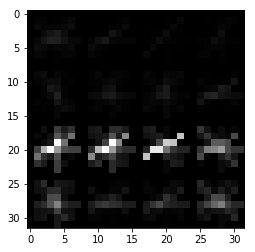

In [21]:
#zostawić?
plt.imshow(hog_features_train[1][1], cmap=plt.cm.gray)

In [54]:
#creating shallow classifier using hog features
hog_clf = LinearSVC(C=2)
hog_fitted = hog_clf.fit(features_hog_train, np.asarray(y_train))  


In [55]:
hog_predicted = hog_fitted.predict(features_hog_test)
hog_predicted.shape

(2250,)

In [56]:

print(accuracy_score(hog_predicted, y_test))
confusion_matrix(hog_predicted, y_test)


0.43822222222222224


array([[107,   6,  23,  11,  23,   5,  12,  11,  27,   4],
       [ 13, 133,  12,  19,   5,  10,  18,   5,  21,  38],
       [ 19,   0,  70,  21,  26,  27,  29,  21,   8,   3],
       [  2,   8,  14,  40,  18,  30,  17,  13,   1,   4],
       [  3,   4,  10,   8,  44,   6,   5,  12,   0,   2],
       [  5,   1,  35,  44,  16,  88,  13,  25,   3,  12],
       [ 11,  13,  22,  35,  25,  29, 145,   5,   9,   3],
       [  9,   6,  11,  28,  41,  27,  10, 122,   6,   9],
       [ 52,  29,  13,   3,  19,   1,   8,   4, 125,  18],
       [  9,  21,   4,  11,  11,   4,   4,  10,  16, 112]], dtype=int64)

In [51]:
from sklearn.model_selection import GridSearchCV
hyperparameters={'C':[0.001, 0.01, 0.1, 1, 2,5]}
clf_hog_cv = GridSearchCV(LinearSVC(verbose=1, random_state=1), hyperparameters, cv=2, verbose=1, n_jobs=-1,return_train_score=True)

model_hog_gridCV = clf_hog_cv.fit(features_hog_train, np.asarray(y_train))
#best acc using C=2, about 0.44 on test set

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   25.8s finished


[LibLinear]

In [53]:
model_hog_gridCV.cv_results_

{'mean_fit_time': array([0.6950866 , 0.70285249, 1.19491208, 2.36820626, 3.53367257,
        6.18408477]),
 'std_fit_time': array([0.00781572, 0.06250119, 0.03903544, 0.00603509, 0.01562285,
        0.06421578]),
 'mean_score_time': array([0.0233928 , 0.03123987, 0.00781381, 0.01561725, 0.01562428,
        0.00777233]),
 'std_score_time': array([7.84289837e-03, 1.56186819e-02, 7.81381130e-03, 2.02655792e-06,
        4.29153442e-06, 7.77232647e-03]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 2, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 2},
  {'C': 5}],
 'split0_test_score': array([0.19776268, 0.31362365, 0.40950859, 0.44346784, 0.44706352,
        0.44107072]),
 'split1_test_score': array([0.2102523 , 0.33880657, 0.39887865, 0.42811374, 0.43251902,
        0.42330797]),
 'mean_test_score': array([0.204 , 0.3262, 0.4042, 0.4358,

## Creating svm classifier

In [5]:
to_norm = features_inception_train.max()
to_norm

31.990528

In [32]:
time_start = time.time()
#małe C- underfituje 
clf_linear = LinearSVC(verbose=1, C=0.1)
print("model created")
fitted_inception = clf_linear.fit(features_inception_train/to_norm, np.asarray(y_train))  
print("model fitted")
print("time:", time.time()-time_start)

model created
[LibLinear]model fitted
time: 57.443443775177


In [33]:
inception_predicted_train = fitted_inception.predict(features_inception_train)
print(accuracy_score(inception_predicted_train, np.asarray(y_train)))
print(confusion_matrix(inception_predicted_train, np.asarray(y_train)))

0.9722
[[453   0   3   0   0   0   0   0   3   1]
 [  0 480   0   0   0   0   0   0   0   0]
 [  3   0 519   8  13   0  12   1   4   0]
 [  0   0   0 504   4   2   1   0   0   0]
 [  2   0   0   1 447   0   6   2   0   0]
 [  0   0   1   4   2 499   1   1   0   0]
 [  0   0   4   4   6   1 464   0   0   0]
 [  2   0   0   1   7   1   0 505   0   0]
 [  4   0   0   0   4   1   0   0 491   0]
 [ 12   7   0   1   3   0   1   0   5 499]]


In [34]:
inception_predicted_test = fitted_inception.predict(features_inception_test/to_norm)
print(accuracy_score(inception_predicted_test, np.asarray(y_test)))
print(confusion_matrix(inception_predicted_test, np.asarray(y_test)))


0.7622222222222222
[[182   2  11   6  11   2   1   5  10   3]
 [  2 194   3   3   0   0   0   0   3   7]
 [  4   0 146  13  10   9  16   9   4   1]
 [  4   1  11 132   9  32  18   7   2   4]
 [  4   0  26  10 159   8  11  16   6   3]
 [  1   1   2  24   2 156   3   8   2   0]
 [  2   0  11  11  14   5 210   4   2   1]
 [  5   0   3  12  17  12   0 176   0   1]
 [ 23   5   0   2   5   1   1   0 184   9]
 [  3  18   1   7   1   2   1   3   3 176]]


## Using random CV to select best parameters

In [30]:
#random hyperparameter search  using cross-validation


hyperparameters={'C':[0.001, 0.01, 0.1, 1]}
clf_cv = GridSearchCV(LinearSVC(verbose=1, random_state=1), hyperparameters, cv=2, verbose=1, n_jobs=-1,return_train_score=True)

model_gridCV = clf_cv.fit(features_inception_train/to_norm, np.asarray(y_train))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.6min finished


[LibLinear]

In [31]:
model_gridCV.cv_results_
#best results using C==0.1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([74.20586073, 74.73808491, 92.75506938, 88.48551345]),
 'std_fit_time': array([ 2.92270839,  6.20643818,  3.73495972, 11.05346799]),
 'mean_score_time': array([17.26347899, 21.9524467 ,  9.46322083,  1.56676674]),
 'std_score_time': array([1.61725235, 5.02536583, 5.51136708, 0.37964725]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.64522573, 0.69676388, 0.72273272, 0.70914902]),
 'split1_test_score': array([0.66359632, 0.71565879, 0.73648378, 0.71285543]),
 'mean_test_score': array([0.6544, 0.7062, 0.7296, 0.711 ]),
 'std_test_score': array([0.00918529, 0.00944745, 0.00687552, 0.0018532 ]),
 'rank_test_score': array([4, 3, 1, 2]),
 'split0_train_score': array([0.71846215, 0.86663997, 0.98438126, 1.        ]),
 'split1_train_score': array([0.71634039, 0.86136636, 

In [ ]:
#creating another CV search around C==0.1

## Using gradient boosting as alternative model

In [39]:
time_start = time.time()

clf_gbc = RandomForestClassifier(verbose=1)
print("model created")
fitted_inception_gbc = clf_gbc.fit(features_inception_train/to_norm, np.asarray(y_train))  
print("model fitted")
print("time:", time.time()-time_start)

model created
model fitted
time: 9.75406551361084


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.7s finished


In [40]:
inception_predicted_gbc_test = fitted_inception_gbc.predict(features_inception_test/to_norm)
print(accuracy_score(inception_predicted_gbc_test, np.asarray(y_test)))
print(confusion_matrix(inception_predicted_gbc_test, np.asarray(y_test)))
#chujowy znowu

0.4666666666666667
[[117  12  38  25  31  11  13  17  33  27]
 [ 17 159   7  10   4   6   3   4  17  28]
 [ 25   5  67  30  29  26  39  22  14   1]
 [  6   6  20  71  19  47  43  21   5   4]
 [ 13   0  32  16  93   9  35  22  11   8]
 [  4   2  12  22   1 101   6  20   5   1]
 [ 12   1  17  21  23   7 116   4   2   4]
 [  4   1   9  12  21  15   1 107   5   3]
 [ 19  12   9   9   3   2   5   7 105  15]
 [ 13  23   3   4   4   3   0   4  19 114]]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


## Using PCA to reduce dimensionality to prevent overfitting

pca finished


Text(0,0.5,'cumulative explained variance')

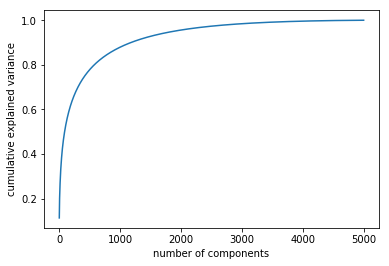

In [12]:
pca = PCA().fit(features_inception_train/to_norm)
print("pca finished")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


Using enough components to capture roughly 0.9 of variance

In [23]:
pca_reduced= PCA(n_components= 2000,svd_solver='randomized', random_state=1).fit(features_inception_train/to_norm)
pca_reduced_train= pca_reduced.transform(features_inception_train/to_norm)
pca_reduced_test= pca_reduced.transform(features_inception_test/to_norm)

In [13]:
#using cross validation to find optimal C
#random hyperparameter search  using cross-validation

hyperparameters={'C':[0.001, 0.01, 0.1, 1]}
clf_pca_cv = GridSearchCV(LinearSVC(verbose=1, random_state=1), hyperparameters, cv=2, verbose=1, n_jobs=-1,return_train_score=True)

model_pca_gridCV = clf_pca_cv.fit(pca_reduced_train, np.asarray(y_train))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   33.8s finished


[LibLinear]

In [14]:
model_pca_gridCV.cv_results_
#results are roughly the same as without pca transformation

{'mean_fit_time': array([2.38559389, 2.56342733, 3.79139304, 6.63600945]),
 'std_fit_time': array([0.00781107, 0.25171721, 0.11714768, 0.4000833 ]),
 'mean_score_time': array([0.0781033 , 0.08591449, 0.05467248, 0.04686248]),
 'std_score_time': array([3.12440395e-02, 3.90466452e-02, 7.80725479e-03, 8.34465027e-07]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.63923292, 0.69636436, 0.71314423, 0.67439073]),
 'split1_test_score': array([0.65798959, 0.71365639, 0.73127753, 0.69603524]),
 'mean_test_score': array([0.6486, 0.705 , 0.7222, 0.6852]),
 'std_test_score': array([0.00937833, 0.00864601, 0.00906665, 0.01082225]),
 'rank_test_score': array([4, 2, 1, 3]),
 'split0_train_score': array([0.69203044, 0.82138566, 0.94072887, 0.99359231]),
 'split1_train_score': array([0.6911706 , 0.821813

In [24]:
to_norm_pca = pca_reduced_train.max()
#zmienić na scaler

In [25]:
#using svm to classify test data
clf_pca = LinearSVC(verbose=1, C=0.1)
print("model created")
fitted_inception_pca = clf_pca.fit(pca_reduced_train/to_norm_pca, np.asarray(y_train))  

predicted_svm_pca = fitted_inception_pca.predict(pca_reduced_test/to_norm_pca)

model created
[LibLinear]

In [26]:
print(accuracy_score(predicted_svm_pca, y_test))
confusion_matrix(predicted_svm_pca, y_test)
#accuracy is lower than using data without pca transformation

0.7271111111111112


array([[168,   3,  19,   7,  11,   3,   0,   8,  12,   5],
       [  3, 193,   2,   3,   0,   0,   0,   0,   4,  11],
       [  6,   0, 116,  11,   6,   7,   9,   8,   1,   0],
       [  0,   1,   9, 122,   7,  28,  14,   7,   4,   2],
       [  8,   0,  29,  12, 144,   8,   9,  16,   4,   4],
       [  1,   0,   4,  15,   1, 157,   5,  10,   0,   0],
       [  3,   1,  25,  28,  26,   7, 222,   5,   1,   1],
       [  1,   0,   6,   8,  28,  12,   1, 166,   1,   0],
       [ 32,   5,   3,   5,   5,   1,   0,   2, 176,  10],
       [  8,  18,   1,   9,   0,   4,   1,   6,  13, 172]], dtype=int64)

In [115]:
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

## Creating classifier neural net on top of inception architecture

In [27]:
features_inception_train.shape

(5000, 18432)

In [29]:
from keras.utils import np_utils

# one-hot encode the labels
y_train_onehot = np_utils.to_categorical(y_train, 10)
y_test_onehot = np_utils.to_categorical(y_test, 10)

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model_custom= Sequential()
model_custom.add(Dense(units=400, input_dim=18432, activation='relu'))
model_custom.add(Dropout(0.5))
model_custom.add(Dense(units=10, activation='softmax'))

model_custom.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [62]:
model_custom.fit(features_inception_train, y_train_onehot, epochs=25, batch_size=50, verbose=2, validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
 - 13s - loss: 0.0570 - acc: 0.9943 - val_loss: 0.9137 - val_acc: 0.7340
Epoch 2/5
 - 13s - loss: 0.0579 - acc: 0.9915 - val_loss: 0.9364 - val_acc: 0.7370
Epoch 3/5
 - 14s - loss: 0.0494 - acc: 0.9948 - val_loss: 0.9546 - val_acc: 0.7320
Epoch 4/5
 - 21s - loss: 0.0477 - acc: 0.9938 - val_loss: 0.9483 - val_acc: 0.7310
Epoch 5/5
 - 18s - loss: 0.0452 - acc: 0.9945 - val_loss: 0.9601 - val_acc: 0.7300


In [63]:
predicted_nn=model_custom.evaluate(features_inception_test,y_test_onehot)

2250/2250 [==============================] - 3s 1ms/step


In [64]:
predicted_nn

[0.856459191110399, 0.7573333334392971]

Obtaining almost 100% accuracy on training data and 

## Using t-sne technique to visualise CNN codes

In [86]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features_inception)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 37.217s...
[t-SNE] Computed neighbors for 5000 samples in 1458.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 16.995504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.857384
[t-SNE] Error after 300 iterations: 3.211091
t-SNE done! Time elapsed: 1672.0785403251648 seconds


In [168]:
pca_df = pd.DataFrame({'x1':pca_results[:,0], 'x2':pca_results[:,1], 'label':y_train})
pca_df.head()

,x1,x2,label
0,-17.168783,-0.092451,7
1,-45.286457,5.570854,8
2,-27.364687,-5.980571,0
3,-43.765614,5.389830,6
4,59.035255,-48.107105,1


In [135]:
import pandas as pd
tsne_df = pd.DataFrame({'x1':tsne_results[:,0], 'x2':tsne_results[:,1], 'label':y_train})
tsne_df.head()

,x1,x2,label
0,-0.219118,-3.158205,7
1,0.125929,1.402257,8
2,0.381148,2.868009,0
3,-1.993657,-2.305661,6
4,-4.918993,0.496868,1


In [167]:
#using pca to obtain lower-dimension dataset
time_start = time.time()
pca = PCA(n_components=2, random_state=1, svd_solver='randomized')
pca_results = pca.fit_transform(features_inception)

print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 6.54068398475647 seconds


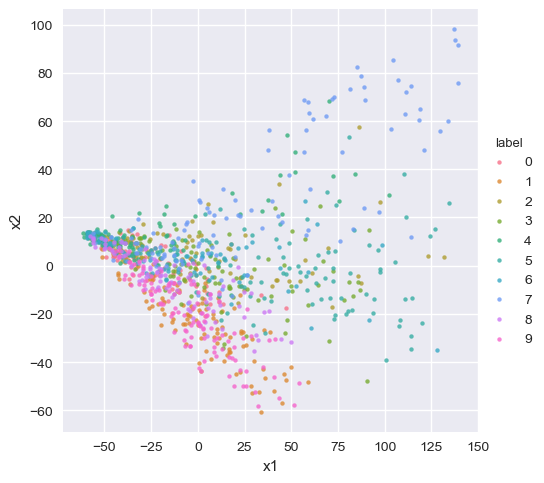

In [172]:
import seaborn as sns
sns.set(rc={'figure.dpi':100})
sns.lmplot(x='x1', y='x2',
                hue='label',
                data=pca_df.head(1000),
           fit_reg=False,
           scatter_kws={"s": 10}
                )

In [87]:
np.save("backups/t-sne-1.npy", tsne_results)

## Misc

In [73]:
%matplotlib inline

In [57]:
#displaying image testing
#img_path = 'a.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#b=image.img_to_array(img)
#img.show()
#Image.fromarray(b.astype('uint8'), 'RGB').show()


a=x_train[1]*255
image2 = Image.fromarray(a.astype('uint8'), 'RGB')
#image2=image2.resize((299,299), Image.NEAREST)
image2.show()
#a=image.img_to_array(image2)
#a

TypeError: Cannot handle this data type